In [165]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#supressing warnings
warnings.filterwarnings('ignore')

# Setting float format to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

In [166]:
# Load the data from the CSV file and the Data Dictionary
loan_data = pd.read_csv('loan.csv')

In [167]:
# Display the first few rows of the loan data
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.00,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.00,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.00,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.00,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.00,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN


In [168]:
#Checking shape and info of the loan_data
loan_data.shape, loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


((39717, 111), None)

# Data Cleaning

In [169]:
# Check for missing values in the dataset
missing_values = loan_data.isnull().sum()

# Calculate the percentage of missing values for each column
missing_percentage = (missing_values / len(loan_data)) * 100

# Sort missing values by percentage
missing_data_overview = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage}).sort_values(by='Percentage', ascending=False)

# Display columns with the highest percentage of missing values
missing_data_overview.head(15)

,Missing Values,Percentage
num_il_tl,39717,100.00
num_bc_sats,39717,100.00
num_bc_tl,39717,100.00
num_actv_bc_tl,39717,100.00
num_accts_ever_120_pd,39717,100.00
mths_since_recent_revol_delinq,39717,100.00
num_actv_rev_tl,39717,100.00
mths_since_recent_inq,39717,100.00
num_tl_90g_dpd_24m,39717,100.00
num_tl_30dpd,39717,100.00


In [170]:
# Drop columns with 100% missing values
cleaned_loan_data = loan_data.drop(columns=missing_data_overview[missing_data_overview['Percentage'] == 100].index)

# Recheck for missing values in the cleaned dataset
cleaned_missing_values = cleaned_loan_data.isnull().sum()
cleaned_missing_percentage = (cleaned_missing_values / len(cleaned_loan_data)) * 100

# Display the updated missing data overview
cleaned_missing_data_overview = pd.DataFrame({'Missing Values': cleaned_missing_values, 'Percentage': cleaned_missing_percentage}).sort_values(by='Percentage', ascending=False)

cleaned_missing_data_overview.head(10)

,Missing Values,Percentage
next_pymnt_d,38577,97.13
mths_since_last_record,36931,92.99
mths_since_last_delinq,25682,64.66
desc,12942,32.59
emp_title,2459,6.19
emp_length,1075,2.71
pub_rec_bankruptcies,697,1.75
last_pymnt_d,71,0.18
collections_12_mths_ex_med,56,0.14
chargeoff_within_12_mths,56,0.14


In [171]:
# Drop columns with very high percentages of missing values that are not essential
columns_to_drop = ['next_pymnt_d', 'mths_since_last_record', 'mths_since_last_delinq', 'desc', 'id', 'member_id', 'emp_title', 'url', 'title', 'zip_code']
cleaned_loan_data = cleaned_loan_data.drop(columns=columns_to_drop)

# Drop rows with missing values for essential columns (such as emp_length and emp_title)
cleaned_loan_data = cleaned_loan_data.dropna(subset=['emp_length', 'pub_rec_bankruptcies'])

In [172]:
# Dropping all those columns which have no variation in the data
# Columns - 'pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med','policy_code', 'application_type', '
# acc_now_delinq','chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'

no_var_cols = cleaned_loan_data.columns[cleaned_loan_data.nunique() == 1]
cleaned_loan_data = cleaned_loan_data.drop(columns = no_var_cols)

In [173]:
# Dropping records where loan_status is 'Current' as the loan is in progress and can impact the analysis
cleaned_loan_data = cleaned_loan_data[cleaned_loan_data.loan_status.isin(['Fully Paid','Charged Off'])]

In [174]:
# Dropping columns that are essential for post-loan approval process
post_approval_cols = ['out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d','revol_bal','revol_util','total_acc','pub_rec']

cleaned_loan_data = cleaned_loan_data.drop(columns=post_approval_cols)

In [175]:
cleaned_loan_data.shape

(36847, 22)

# Data Types Correction

In [176]:
# Removing '%' and converting 'int_rate' from string to float
cleaned_loan_data['int_rate'] = cleaned_loan_data['int_rate'].str.rstrip('%').astype(float)

# Removing 'months' from term column and converting the term column to 'int'
cleaned_loan_data['term'] = cleaned_loan_data.term.apply(lambda x : int(x.split()[0]))

# converting into float values
cols_to_convert = ['loan_amnt','funded_amnt']
cleaned_loan_data[cols_to_convert] = cleaned_loan_data[cols_to_convert].astype('float')

# Converting 'pub_rec_bankriptcies' from float to int
cleaned_loan_data['pub_rec_bankruptcies'] = cleaned_loan_data['pub_rec_bankruptcies'].astype('int64')

# Converting columns 'issue_d' and 'earliest_cr_line' to date and time datatype 
cleaned_loan_data['issue_d'] = pd.to_datetime(cleaned_loan_data['issue_d'], format = '%b-%y')
cleaned_loan_data['earliest_cr_line'] = pd.to_datetime(cleaned_loan_data['earliest_cr_line'], format = '%b-%y')

# Converting column 'sub_grade' to numeric data type for better analysis
cleaned_loan_data.sub_grade = pd.to_numeric(cleaned_loan_data.sub_grade.apply(lambda x : x[-1]))

In [177]:
cleaned_loan_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec_bankruptcies
0,5000.00,5000.00,4975.00,36,10.65,162.87,B,2,10+ years,RENT,...,2011-12-01,Fully Paid,credit_card,AZ,27.65,0,1985-01-01,1,3,0
1,2500.00,2500.00,2500.00,60,15.27,59.83,C,4,< 1 year,RENT,...,2011-12-01,Charged Off,car,GA,1.00,0,1999-04-01,5,3,0
2,2400.00,2400.00,2400.00,36,15.96,84.33,C,5,10+ years,RENT,...,2011-12-01,Fully Paid,small_business,IL,8.72,0,2001-11-01,2,2,0
3,10000.00,10000.00,10000.00,36,13.49,339.31,C,1,10+ years,RENT,...,2011-12-01,Fully Paid,other,CA,20.00,0,1996-02-01,1,10,0
5,5000.00,5000.00,5000.00,36,7.90,156.46,A,4,3 years,RENT,...,2011-12-01,Fully Paid,wedding,AZ,11.20,0,2004-11-01,3,9,0


In [178]:
# Converting 'emp_length' from string to int

def emp_length_int(emp_length):
    if emp_length == '10+ years':
        return 10
    elif emp_length == '< 1 year':
        return 0
    else:
        emp_length = emp_length.split(' ')[0]
        return int(emp_length)
    
cleaned_loan_data['emp_length'] = cleaned_loan_data['emp_length'].apply(emp_length_int)

# Derived Columns

In [179]:
# Deriving columns 'issue_month' and 'issue_year' from datetime column 'issue_d'
cleaned_loan_data['issue_month'] =  cleaned_loan_data['issue_d'].dt.month
cleaned_loan_data['issue_year'] = cleaned_loan_data['issue_d'].dt.year

# Hanlding Outliers

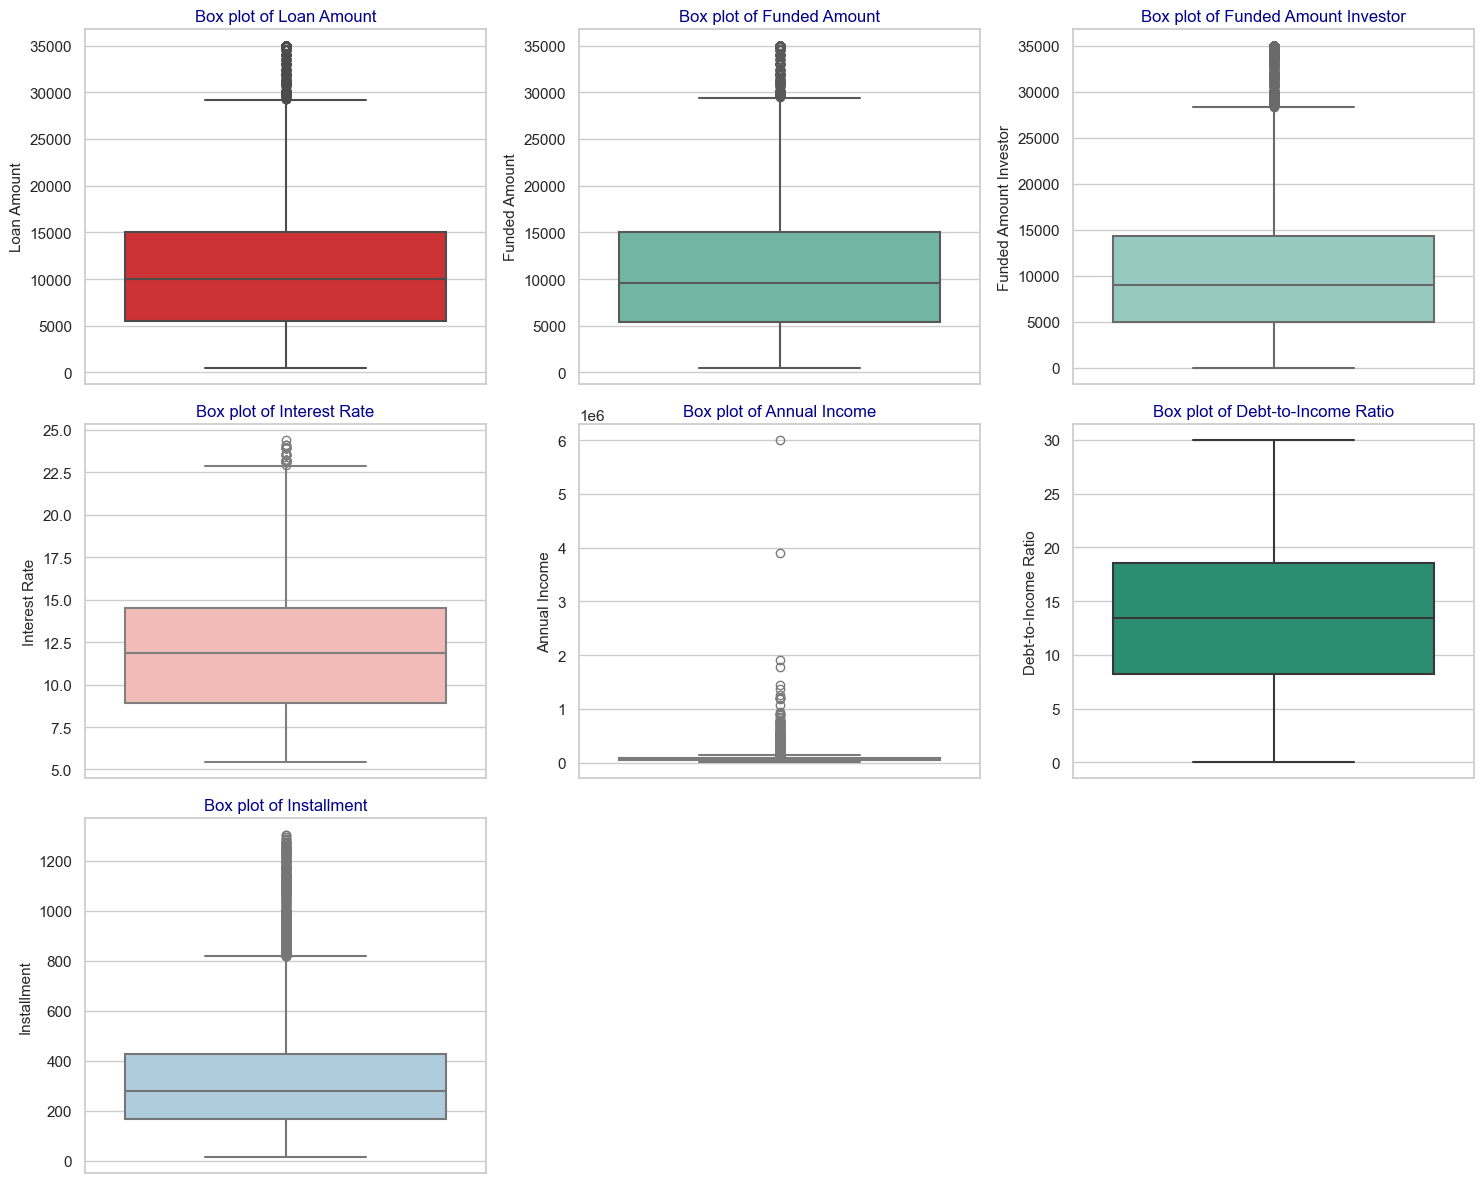

In [180]:
# Set a style for better aesthetics
sns.set(style="whitegrid")

# List of important columns and their respective titles/labels for analysis
columns_to_check = {
    'loan_amnt': 'Loan Amount',
    'funded_amnt': 'Funded Amount',
    'funded_amnt_inv': 'Funded Amount Investor',
    'int_rate': 'Interest Rate',
    'annual_inc': 'Annual Income',
    'dti': 'Debt-to-Income Ratio',
    'installment': 'Installment',
}

# List of colors for each subplot
colors = ['Set1', 'Set2', 'Set3', 'Pastel1', 'Pastel2', 'Dark2', 'Paired']

# Create subplots to visualize outliers with different colors
plt.figure(figsize=(15, 12))

for i, (col, label) in enumerate(columns_to_check.items(), 1):
    plt.subplot(3, 3, i)
    
    # Boxplot with different color palette for each column
    sns.boxplot(data=cleaned_loan_data, y=col, palette=colors[i-1], linewidth=1.5)
    
    # Adding title and labels
    plt.title(f'Box plot of {label}', fontsize=12, color='darkblue')
    plt.ylabel(label, fontsize=11)
    plt.xlabel('')

# Adjust layout
plt.tight_layout()
plt.show()

In [181]:
# Function to remove outliers using IQR
def remove_outliers(df, columns):
    for col in columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter the dataframe to remove outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        
    return df

# List of important columns to check for outliers
columns_to_clean = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'installment']

# Remove outliers from the important columns
cleaned_loan_data_no_outliers = remove_outliers(cleaned_loan_data, columns_to_clean)

# Check the shape of the dataframe before and after
print(f"Original dataframe shape: {cleaned_loan_data.shape}")
print(f"Dataframe shape after removing outliers: {cleaned_loan_data_no_outliers.shape}")

Original dataframe shape: (36847, 24)
Dataframe shape after removing outliers: (33123, 24)


# Univariate Analysis

### Ordered Categorical

In [182]:
# Define a function for plotting bar charts with counts on top of each bar
def plot_categorical_with_counts(data, column, title, xlabel, ylabel):
    plt.figure(figsize=(10, 7))
    ax = sns.countplot(data=data, x=column, palette="viridis", order=data[column].value_counts().index)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45)

    # Adding counts on top of the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.tight_layout()
    plt.show()

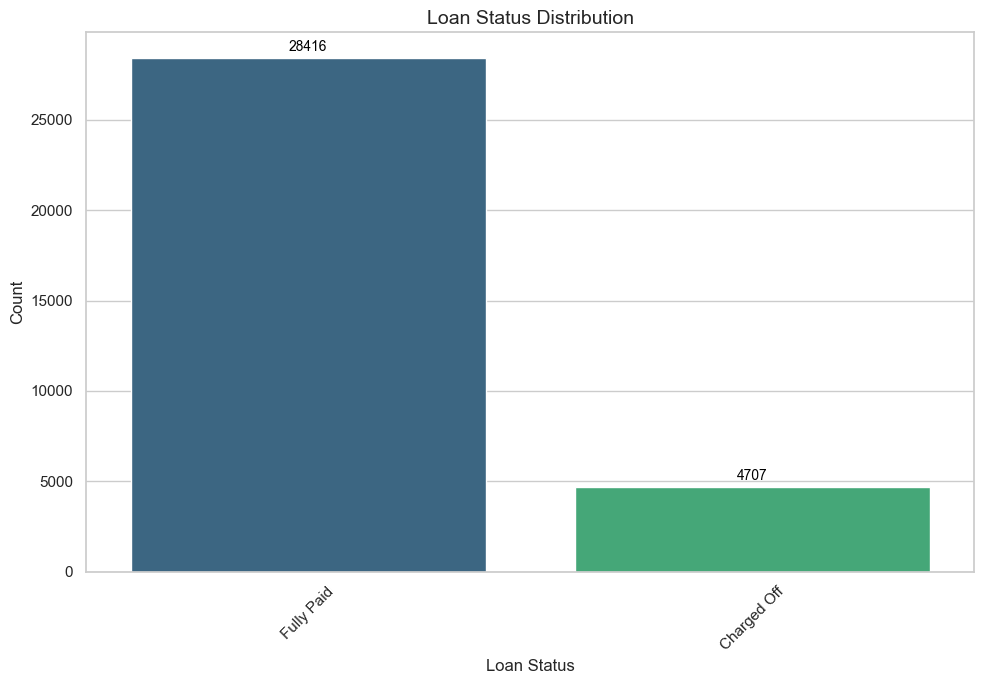

loan_status
Fully Paid     28416
Charged Off     4707
Name: count, dtype: int64


In [183]:
# Plot with counts for each categorical column
plot_categorical_with_counts(cleaned_loan_data_no_outliers, 'loan_status', 'Loan Status Distribution', 'Loan Status', 'Count')
print(cleaned_loan_data_no_outliers['loan_status'].value_counts())

In [184]:
# We will be performing univariate analysis where the loan status == 'Charged Off'
charged_off_data = cleaned_loan_data_no_outliers[cleaned_loan_data_no_outliers['loan_status'] == 'Charged Off']

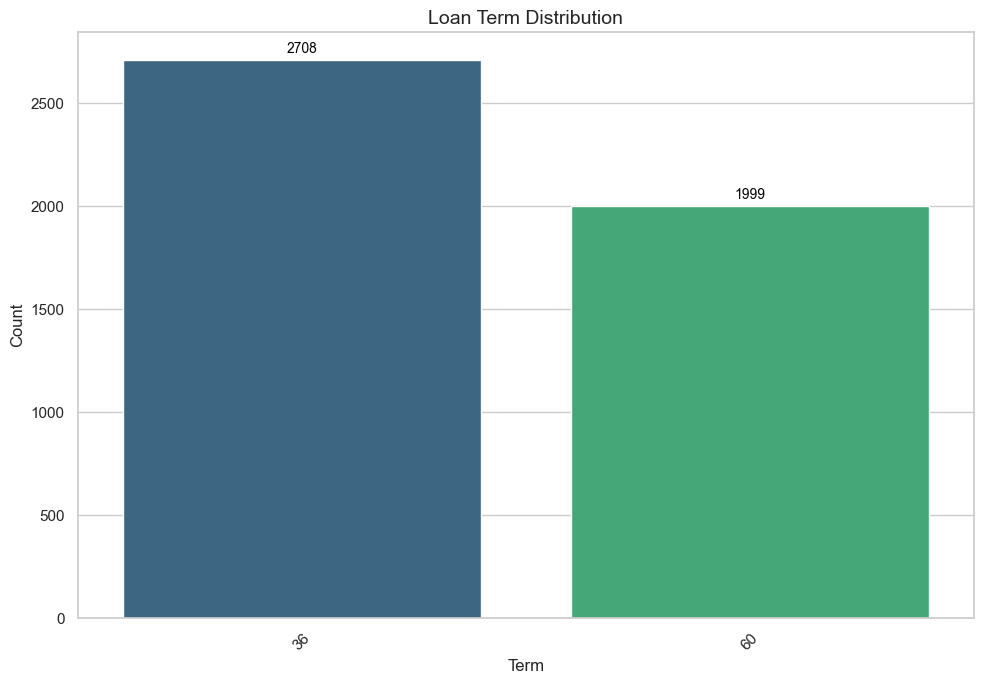

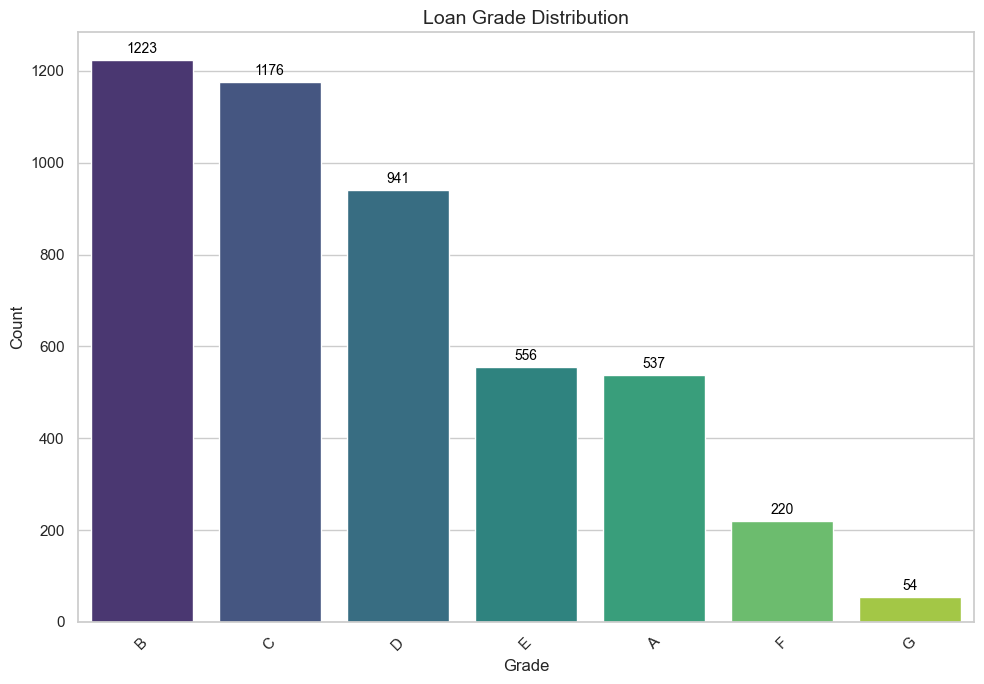

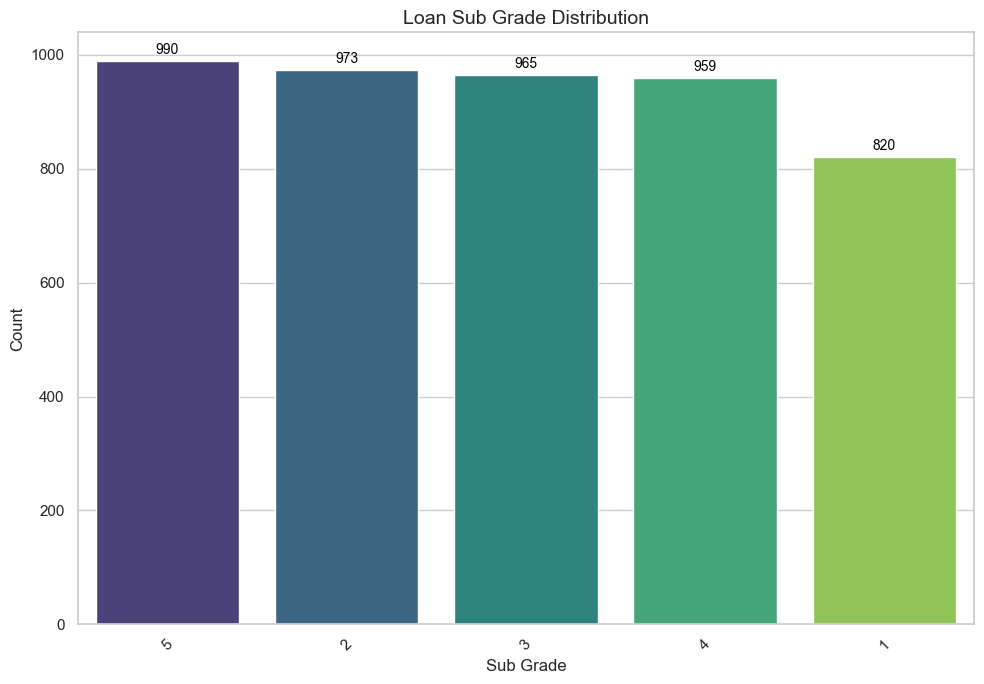

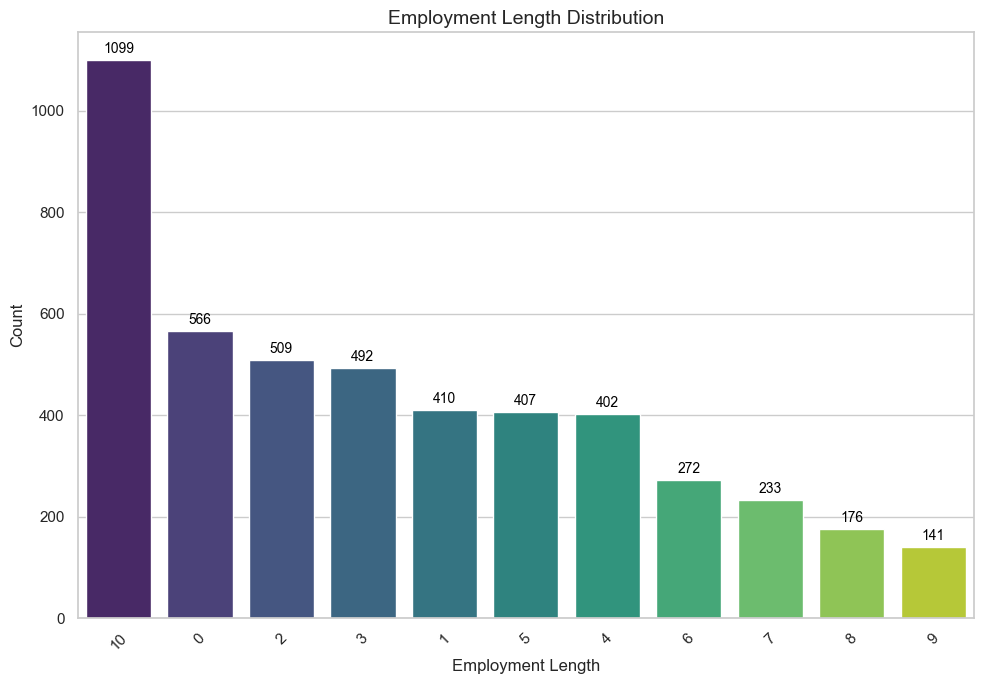

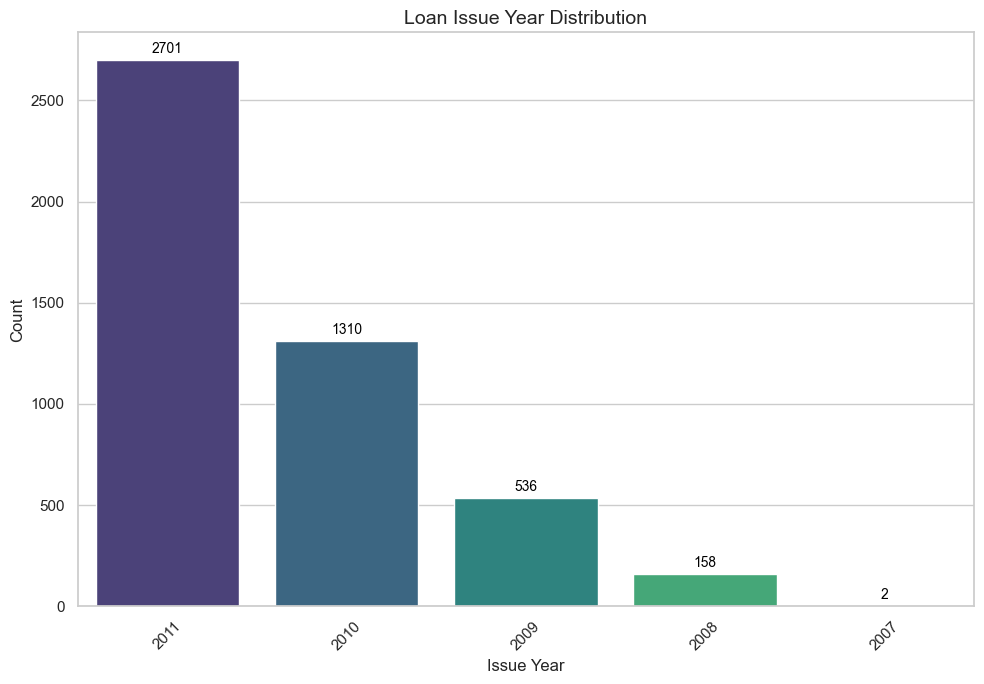

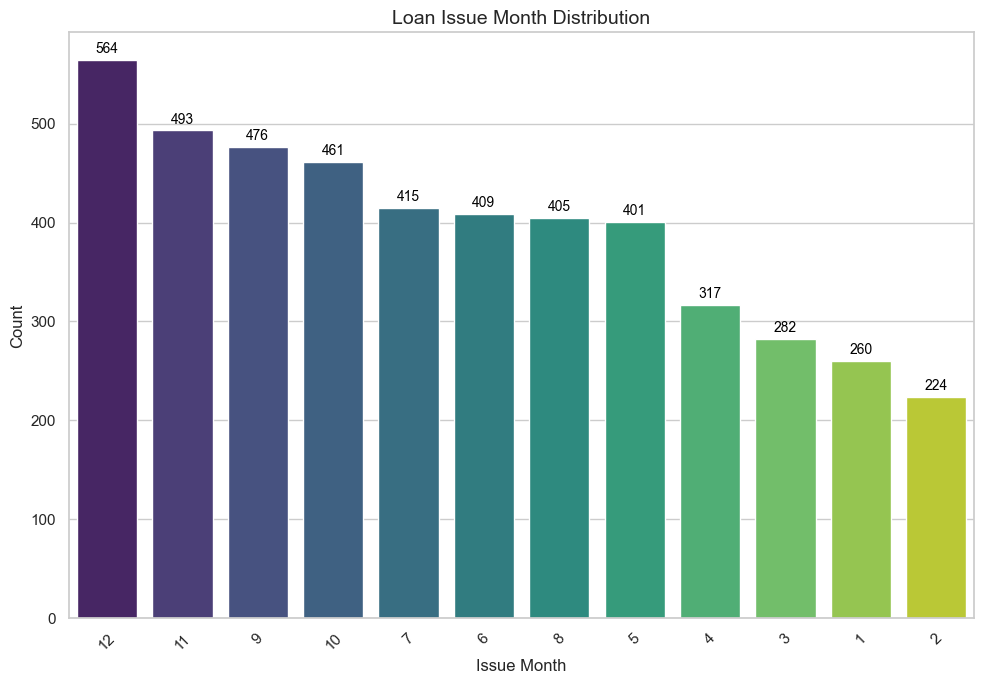

In [185]:
plot_categorical_with_counts(charged_off_data, 'term', 'Loan Term Distribution', 'Term', 'Count')
plot_categorical_with_counts(charged_off_data, 'grade', 'Loan Grade Distribution', 'Grade', 'Count')
plot_categorical_with_counts(charged_off_data, 'sub_grade', 'Loan Sub Grade Distribution', 'Sub Grade', 'Count')
plot_categorical_with_counts(charged_off_data, 'emp_length', 'Employment Length Distribution', 'Employment Length', 'Count')
plot_categorical_with_counts(charged_off_data, 'issue_year', 'Loan Issue Year Distribution', 'Issue Year', 'Count')
plot_categorical_with_counts(charged_off_data, 'issue_month', 'Loan Issue Month Distribution', 'Issue Month', 'Count')

### Univariate Analysis- Ordered Categorical Variables Observation

- More than 2800 applicants have Fully Paid ther Loans.
- More than 2700 applicants choose term as 36 months for the repayment of loan, indicating this is the most popular term among the borrowers.
- 1225 Applicants with credit score B has the highest number of Charged Off loan applicants indicating financial issues.
- Within Grade B, loan applicants with sub grade B5 had highest number of charged off loan applicants.
- Applicants with more than 10 years of experience indicate that better experience doesnt higky correlate with loan repayment.
- In the year 2011, highest number of loan applicants were charged off indicating many of them were suffering from financial issues.
- December has the highest number of loan applicants that were charged-off indicating that during holiday season many of them took loans that were charged off.

### Uordered Categorical

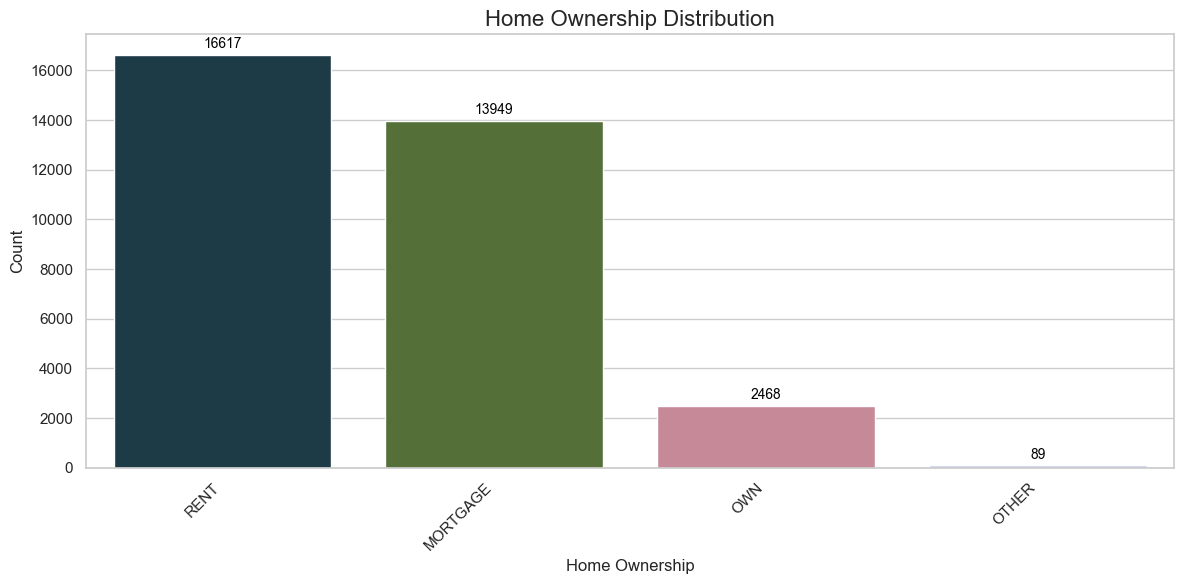

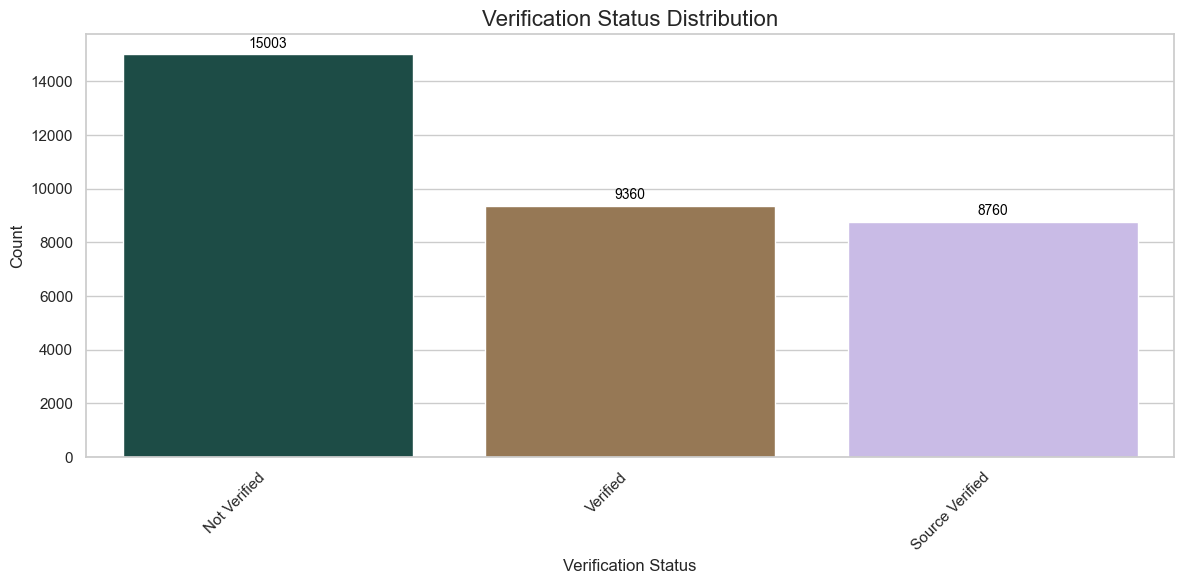

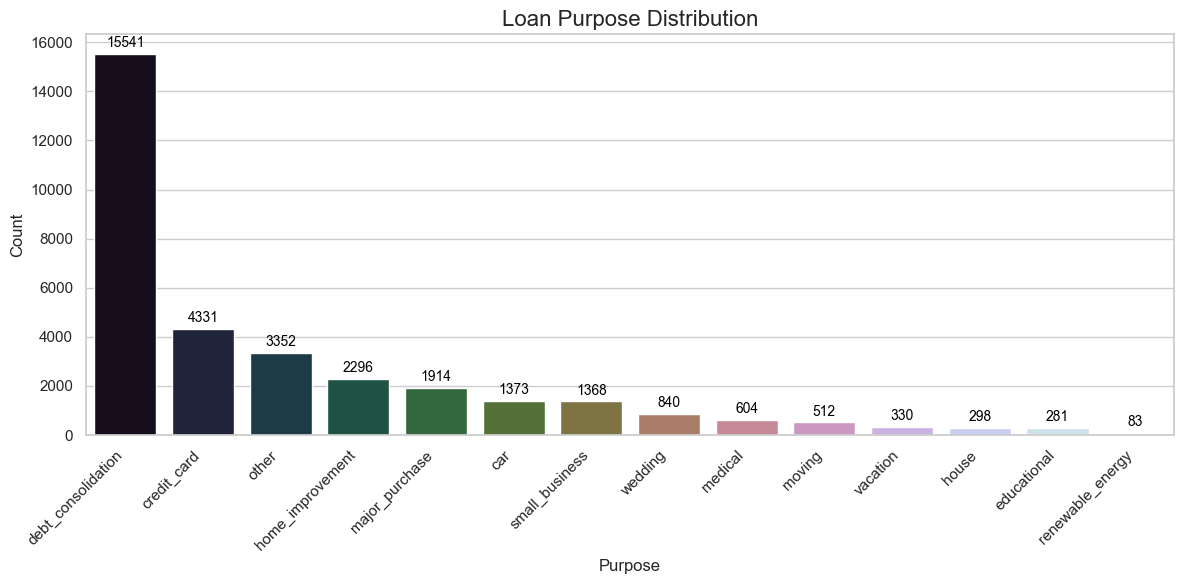

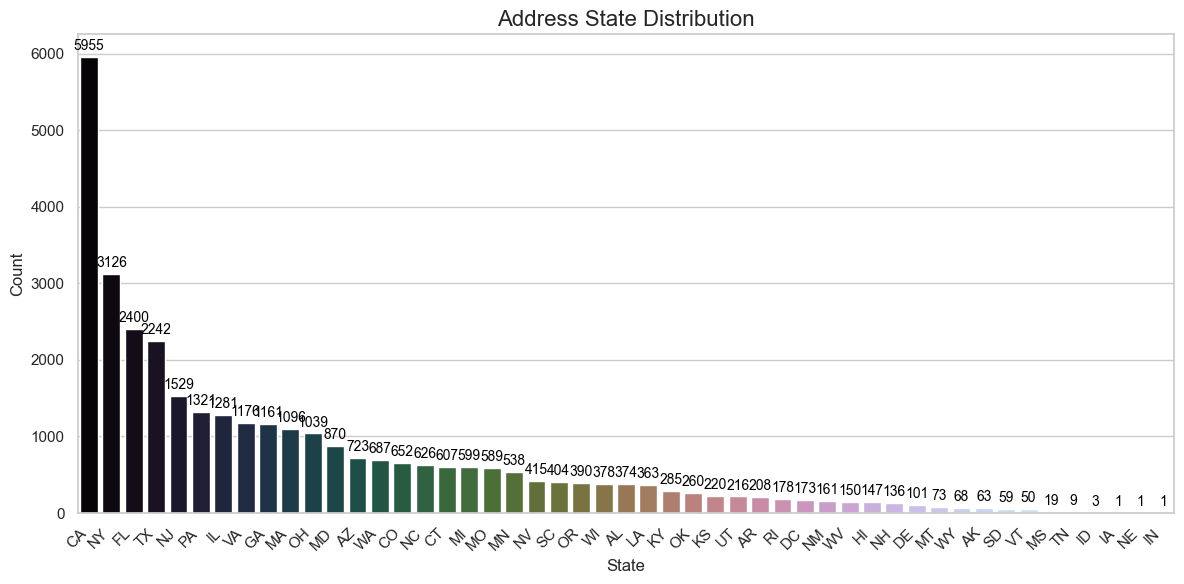

In [186]:
# Select the columns for analysis
unordered_columns = ['home_ownership', 'verification_status', 'purpose', 'addr_state']

# Define a function for univariate analysis of unordered categorical variables
def plot_unordered_categorical(data, column, title, xlabel, ylabel):
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, palette="cubehelix")
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # Add counts on top of the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.tight_layout()
    plt.show()

# Generate plots for each unordered categorical variable
plot_unordered_categorical(cleaned_loan_data_no_outliers, 'home_ownership', 'Home Ownership Distribution', 'Home Ownership', 'Count')
plot_unordered_categorical(cleaned_loan_data_no_outliers, 'verification_status', 'Verification Status Distribution', 'Verification Status', 'Count')
plot_unordered_categorical(cleaned_loan_data_no_outliers, 'purpose', 'Loan Purpose Distribution', 'Purpose', 'Count')
plot_unordered_categorical(cleaned_loan_data_no_outliers, 'addr_state', 'Address State Distribution', 'State', 'Count')

### Observation

- Loan Applicants who don't own their home and are staying on rent tend to have higher possiblity of not repaying the charged off loan.
- More than 1700 loan applicants that were not verified took loans that were charged off.
- Loan Applicants who applied for loans to consolidate the debt have the highest rate of charged off loans.
- Address state 'CA' has the highest number of loan applicants that were charged off.

## Numerical or Quantitative Variables

- loan amount
- annual income
- dti
- interest rate
- installment
- Public Record Bankruptcies
- Delinquencies in 2 years
- Inquires in last 6 months 
- Funded Amount
- Open Accounts

In [187]:
# Bucketing loan_amnt_grps, annual_inc_grps, dti_grps, int_rate_grps,installment

charged_off_data['loan_amnt_grps'] = pd.cut(charged_off_data.loan_amnt,bins = 6, labels = ['0-5k','5k-10k','10k-15k','15k-20k','20k-25k','25k-30k'])
charged_off_data['annual_inc_grps'] = pd.cut(charged_off_data.annual_inc,bins = 5, labels = ['0-35k','35k-65k','65k-95k','95k-125k','125k-155k'])
charged_off_data['dti_grps'] = pd.cut(charged_off_data.dti,bins = 5, labels = ['0-6','6-12','12-18','18-24','24-30'])
charged_off_data['int_rate_grps'] = pd.cut(charged_off_data.int_rate,bins = [0, 11.14, 13.49, 16.02, 20, 25], labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High'])
charged_off_data['installment_grps'] = pd.cut(charged_off_data.installment,bins = 5, labels = ['0-150','150-300','300-450','450-600','600-750'])
charged_off_data['funded_amnt_grps'] = pd.cut(charged_off_data.funded_amnt,bins = 6, labels = ['0-5k','5k-10k','10k-15k','15k-20k','20k-25k','25k-30k'])

In [188]:
# Defining function to find count for different plots
def count_cat(ax):
    # Loop to add the counts on top of the bars
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only show labels for non-zero counts
            ax.text(p.get_x() + p.get_width() / 2, height + 0.02, int(height), ha="center")

# Defining a common function to create histplots and print counts
def create_histplot(data, column, title, xlabel, ylabel, kde=True, bins=None, grid_style='-', grid_alpha=0.5):
    plt.figure(figsize=(10, 7))
    ax = sns.histplot(x=column, data=data, kde=kde, bins=bins, palette='colorblind')
    count_cat(ax)
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', linestyle=grid_style, alpha=grid_alpha)
    plt.show()

# Define a common function to create countplots and print counts
def create_countplot(data, column, title, xlabel, ylabel, grid_style='-', grid_alpha=0.5):
    plt.figure(figsize=(10, 7))
    ax = sns.countplot(x=column, data=data, palette='colorblind')
    count_cat(ax)
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', linestyle=grid_style, alpha=grid_alpha)
    plt.show()

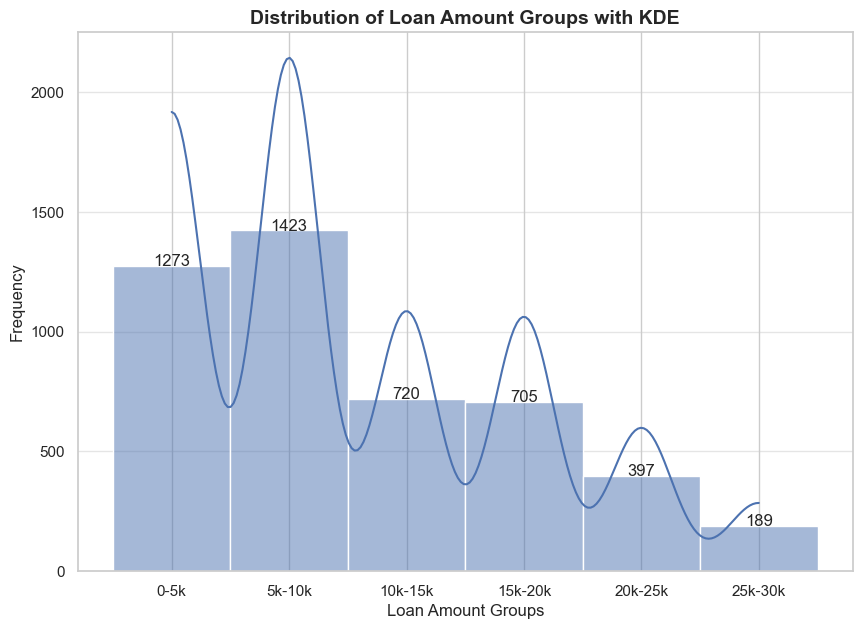

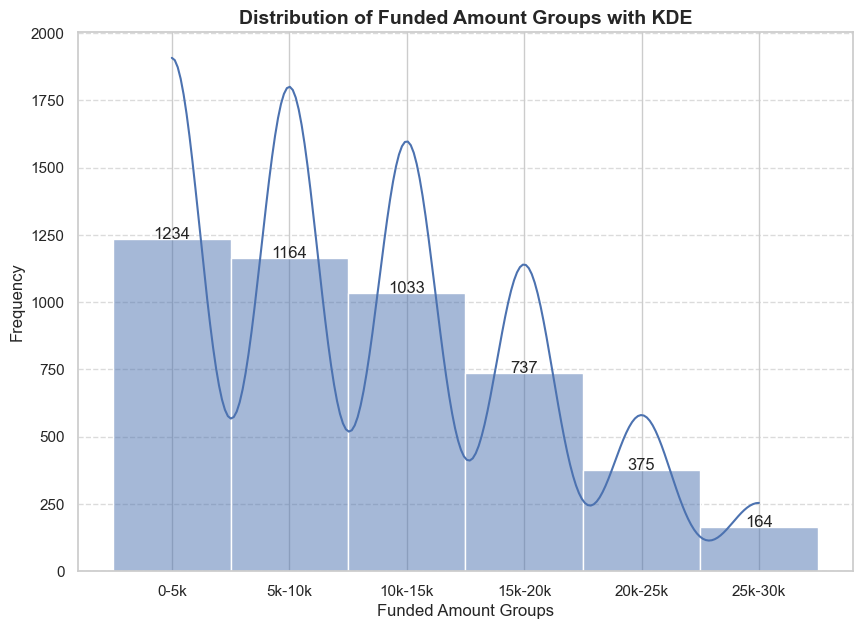

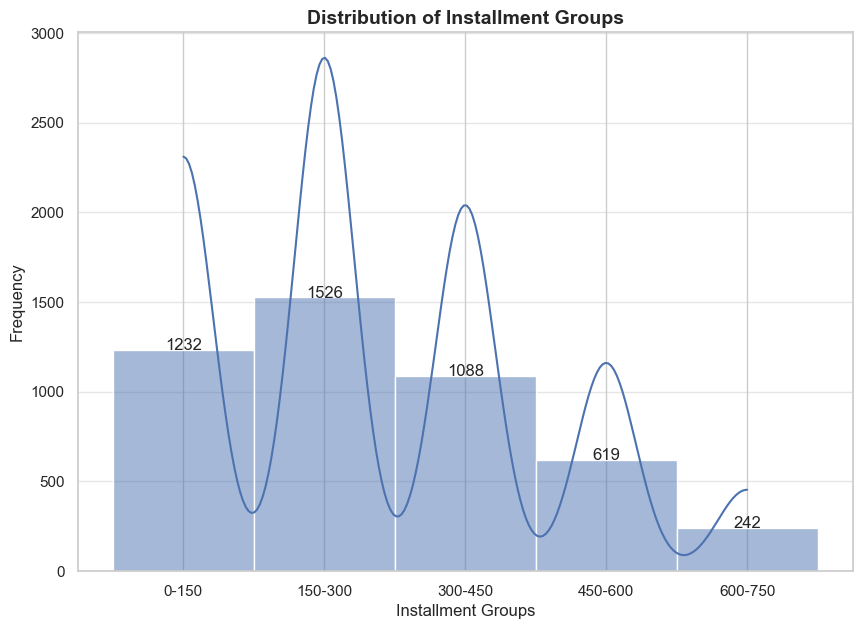

<Figure size 1000x700 with 0 Axes>

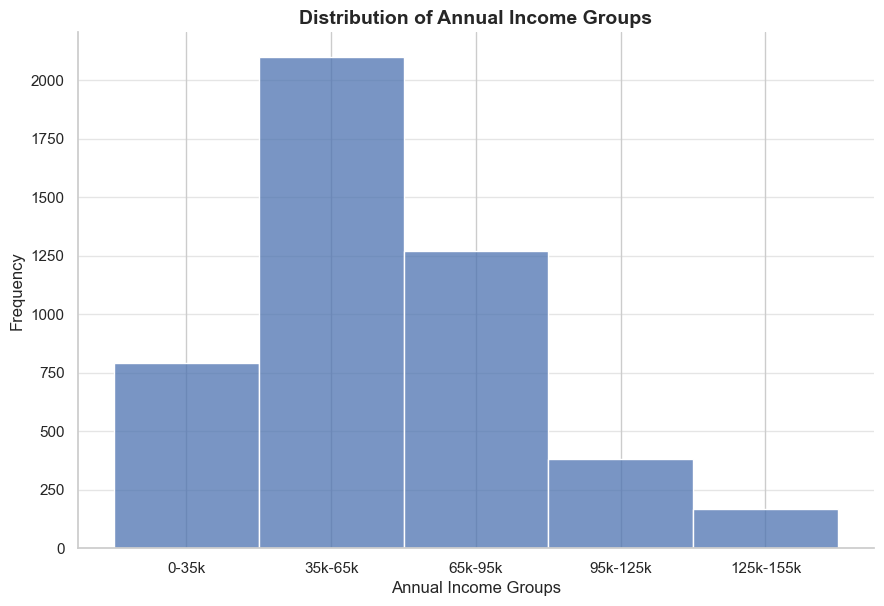

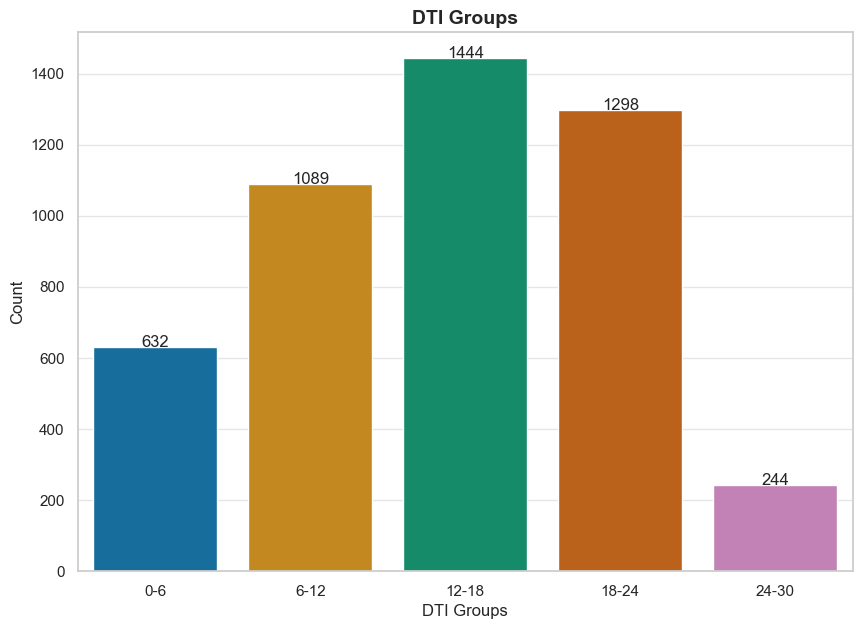

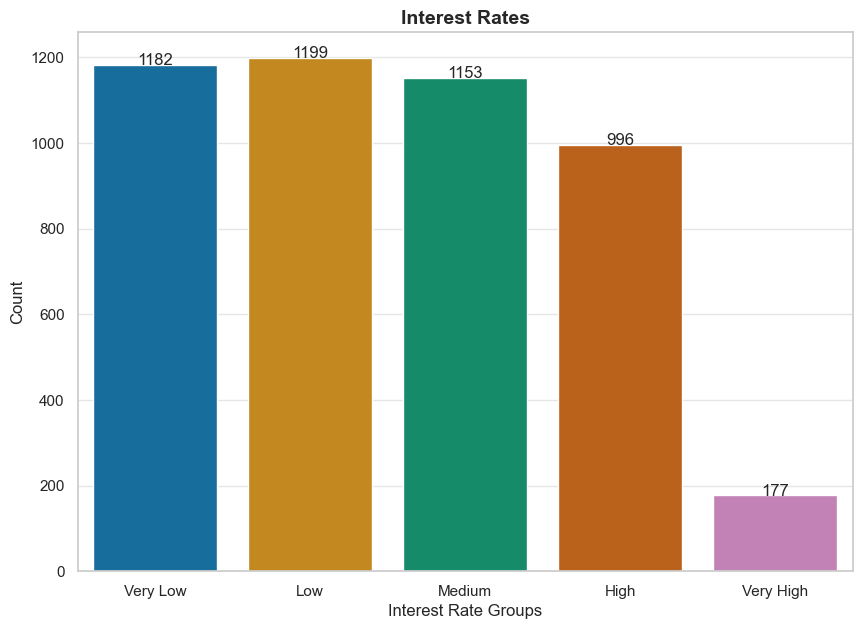

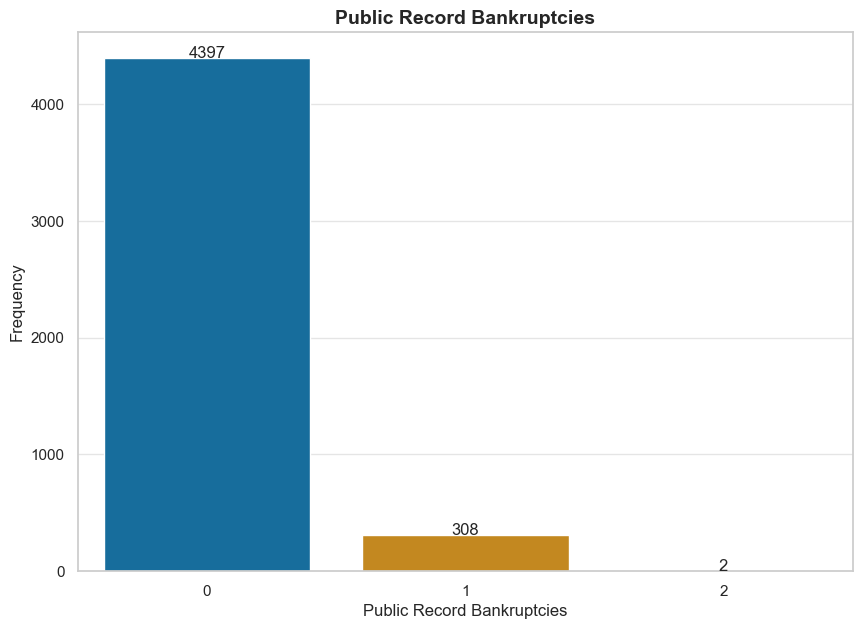

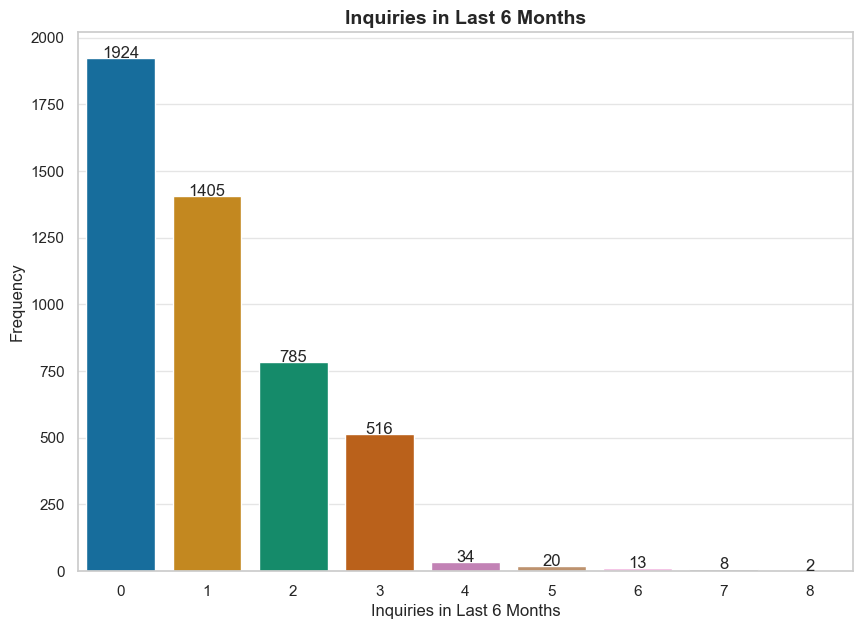

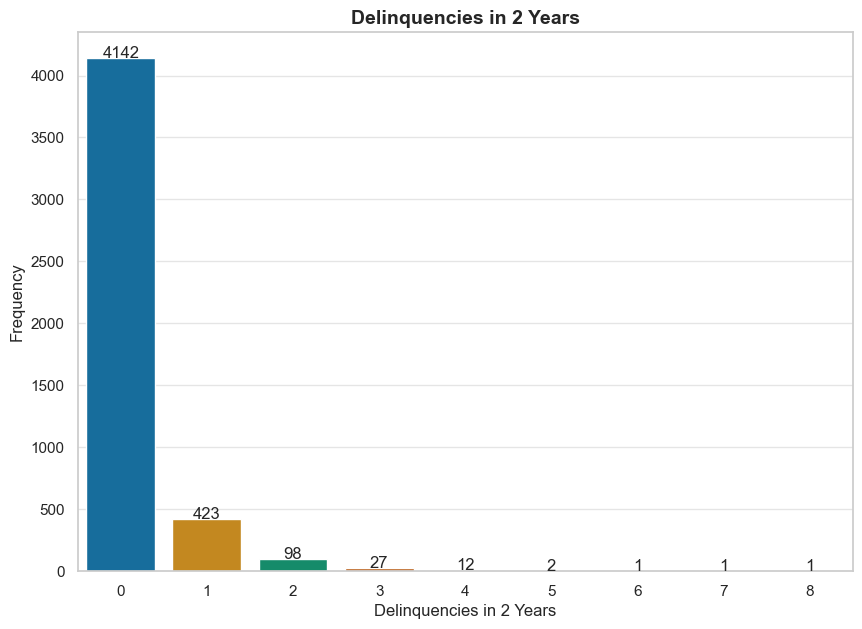

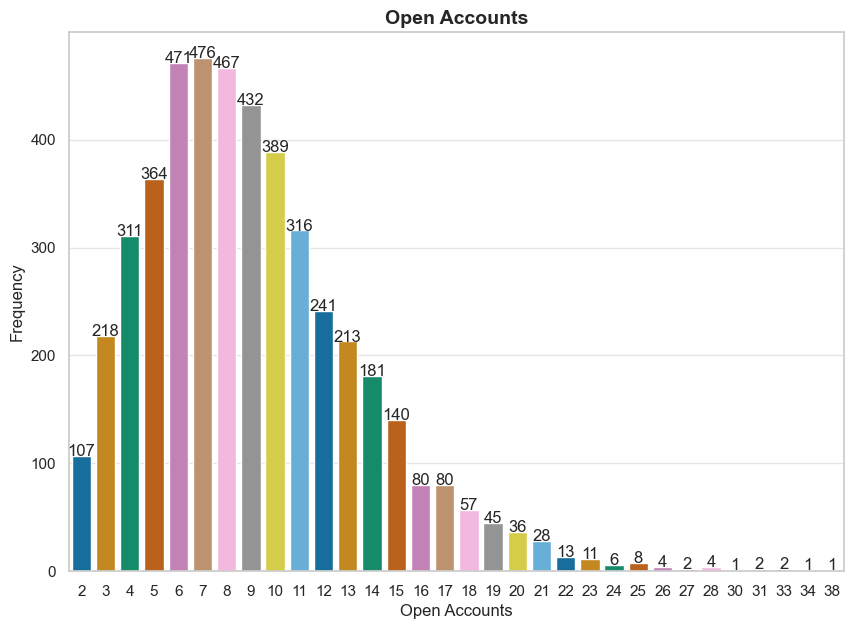

In [189]:
# Plot for Loan Amount Groups
create_histplot(data=charged_off_data, column='loan_amnt_grps', 
                title='Distribution of Loan Amount Groups with KDE', 
                xlabel='Loan Amount Groups', ylabel='Frequency')

# Plot for Funded Amount Groups
create_histplot(data=charged_off_data, column='funded_amnt_grps', 
                title='Distribution of Funded Amount Groups with KDE', 
                xlabel='Funded Amount Groups', ylabel='Frequency', 
                grid_style='--', grid_alpha=0.7)

# Plot for Installment Groups
create_histplot(data=charged_off_data, column='installment_grps', 
                title='Distribution of Installment Groups', 
                xlabel='Installment Groups', ylabel='Frequency', 
                bins=6, grid_style='-', grid_alpha=0.5)

# Displot for annual income groups
plt.figure(figsize=(10, 7))
sns.displot(x='annual_inc_grps', data=charged_off_data, palette='colorblind',aspect=1.5, height=6)
plt.title('Distribution of Annual Income Groups', fontsize=14, weight='bold')
plt.xlabel('Annual Income Groups')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.show()

# Countplot for DTI Groups
create_countplot(data=charged_off_data, column='dti_grps', 
                 title='DTI Groups', xlabel='DTI Groups', ylabel='Count')

# Countplot for Interest Rate Groups
create_countplot(data=charged_off_data, column='int_rate_grps', 
                 title='Interest Rates', xlabel='Interest Rate Groups', ylabel='Count')

# Countplot for Public Record Bankruptcies
create_countplot(data=charged_off_data, column='pub_rec_bankruptcies', 
                 title='Public Record Bankruptcies', xlabel='Public Record Bankruptcies', ylabel='Frequency')

# Countplot for Inquiries in Last 6 Months
create_countplot(data=charged_off_data, column='inq_last_6mths', 
                 title='Inquiries in Last 6 Months', xlabel='Inquiries in Last 6 Months', ylabel='Frequency')

# Countplot for Delinquencies in 2 Years
create_countplot(data=charged_off_data, column='delinq_2yrs', 
                 title='Delinquencies in 2 Years', xlabel='Delinquencies in 2 Years', ylabel='Frequency')

# Countplot for Open Accounts
create_countplot(data=charged_off_data, column='open_acc', 
                 title='Open Accounts', xlabel='Open Accounts', ylabel='Frequency')

## Observation

- Applicants who have loan amounts ranging from 5k to 10k USD tend to not repay the loan that was charged off indicating     potential risk among this group
- Applicants with funded amount between 0 to 5k USD show higher tendency to default on their loans.
- Applicants who have installments between 150 to 300 tend to face difficulties in paying their charged off loans.
- Applicants who have an annual income ranging from 35k to 65k USD show higher tendency to default on their loans.
- Applicants with DTI groups ranging from 12 to 18 tend to default on their loans as compared to other groups.
- Applicants with very low, low and medium interest rates have a higher tendency in defaulting their loans.
- More than 4000 applicants have no record of public bankruptcies showing a lower tendency in defaulting and less than 500 applicants show a slight tendency in defaulting  their loans.
- More than 1750 applicants have no record of credit card inquries.
- More than 3500 applicants have no record of deliquinces in 2 years which is a good sign indicating many of them have paid their installments 30 days past due.
- Applicants that have 6 to 8 accounts open tend to show a higher tendency in defaulting on their loans.

# Bivariate Analysis

In [190]:
# Set theme for clarity
sns.set_theme(style="whitegrid")

# Define a flexible plotting function
def plot_comparison(data, x, y, plot_type="bar", order=None):
    """
    Function to create bar or line plots for given x and y columns with unique bar colors.
    
    Parameters:
        data (DataFrame): The dataset to use for plotting.
        x (str): Column for the x-axis.
        y (str): Column for the y-axis.
        plot_type (str): Type of plot - 'bar' or 'line'.
        order (list): Optional parameter to specify order for categorical x-axis (default: None).
    """
    # Generate a unique color palette for the x categories
    unique_categories = data[x].unique()
    if order:
        unique_categories = order
    palette = dict(zip(unique_categories, sns.color_palette("husl", len(unique_categories))))
    
    plt.figure(figsize=(10, 6))
    
    if plot_type == "bar":
        # Barplot with unique colors per category
        sns.barplot(
            x=x,
            y=y,
            data=data,
            ci=None,
            order=order,
            palette=palette  # Assign unique colors
        )
        plt.xticks(rotation=45)
    elif plot_type == "line":
        sns.lineplot(x=x, y=y, data=data, ci=None, palette="coolwarm")
        plt.xticks(rotation=45)
    
    # Set titles and labels
    plt.title(f"{x.replace('_', ' ').capitalize()} vs {y.replace('_', ' ').capitalize()}", fontsize=14)
    plt.xlabel(x.replace("_", " ").capitalize())
    plt.ylabel(y.replace("_", " ").capitalize())
    plt.tight_layout()
    plt.show()

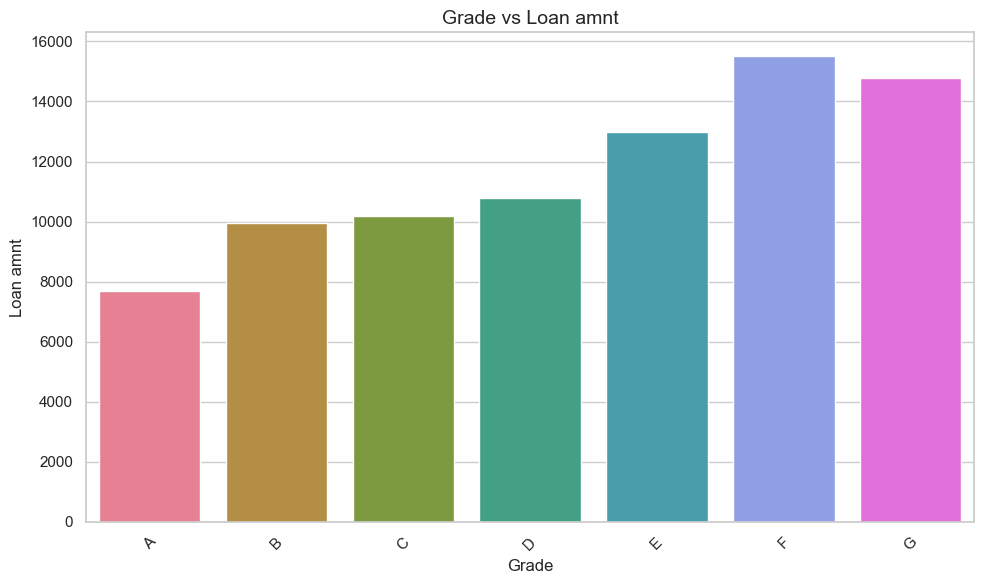

In [191]:
# Loan Amount vs Grade
plot_comparison(charged_off_data, x="grade", y="loan_amnt", plot_type="bar", order=["A", "B", "C", "D", "E", "F", "G"])

# Observation - Applicants with lower credit card grades are taking larger loan amounts which can lead them to not pay the loan amount

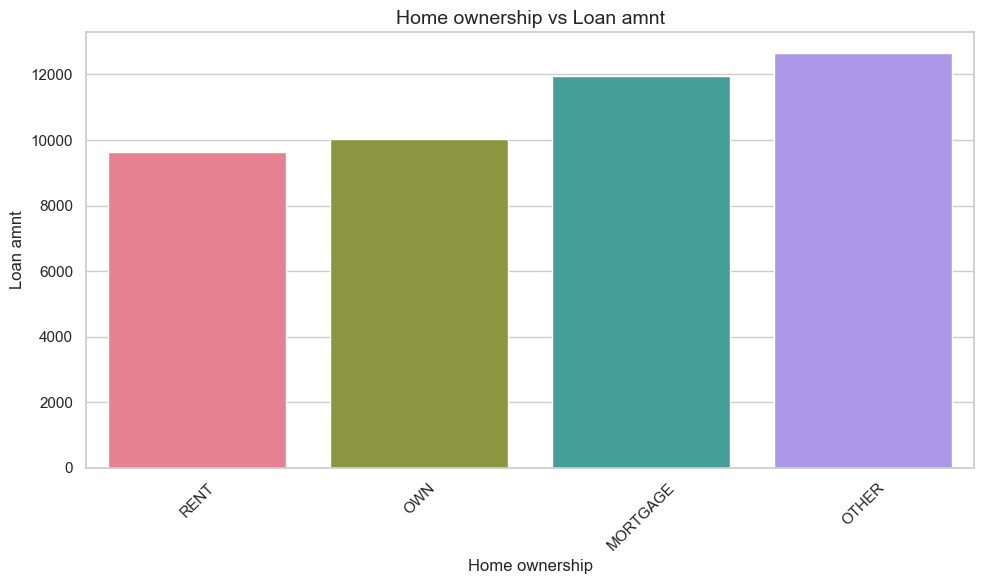

In [192]:
# Loan Amount vs Home Ownership
plot_comparison(charged_off_data, x="home_ownership", y="loan_amnt", plot_type="bar")

# Observation - Applicants with 'Others'as their home ownership tend to have higher loan amounts as compared to people those 
# who Rent,Own or have a Mortgage.

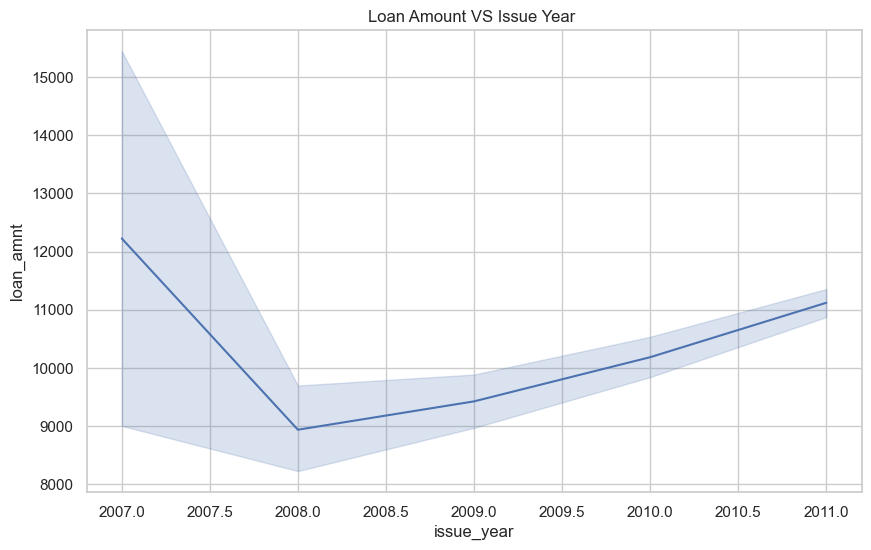

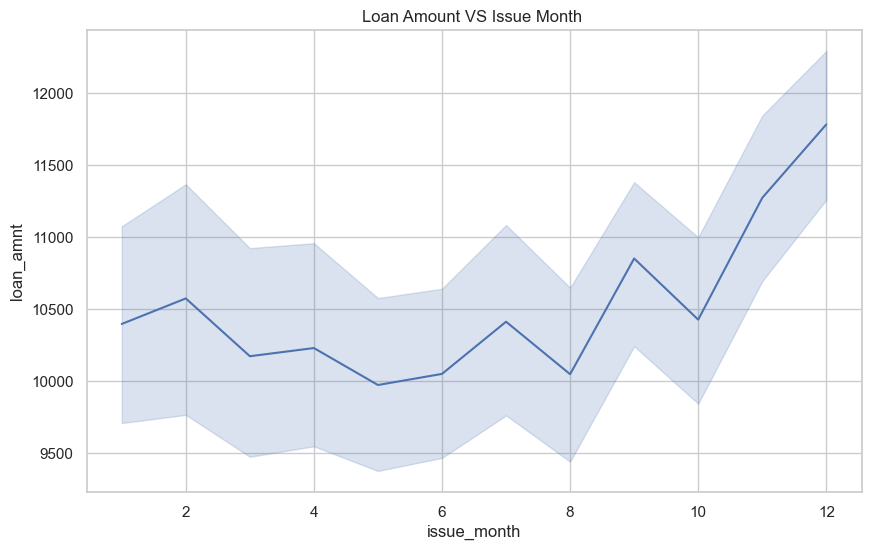

In [193]:
plt.figure(figsize=(10, 6))
sns.lineplot(x = 'issue_year',y='loan_amnt',data=charged_off_data,palette='pastel')
plt.title('Loan Amount VS Issue Year ')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x = 'issue_month',y='loan_amnt',data=charged_off_data,palette='pastel')
plt.title('Loan Amount VS Issue Month ')
plt.show()

# Observation - 
# 1) There was a peak of loan amount in the year 2007 and again in the year 2011 we saw a growth in the loan amount 
#    indicating that in years 2007 and 2011, applicants have taken larger loan amounts

# 2) There was a peak of loan amount in the month of December indicating many individuals might have take loans during 
#    the holiday season

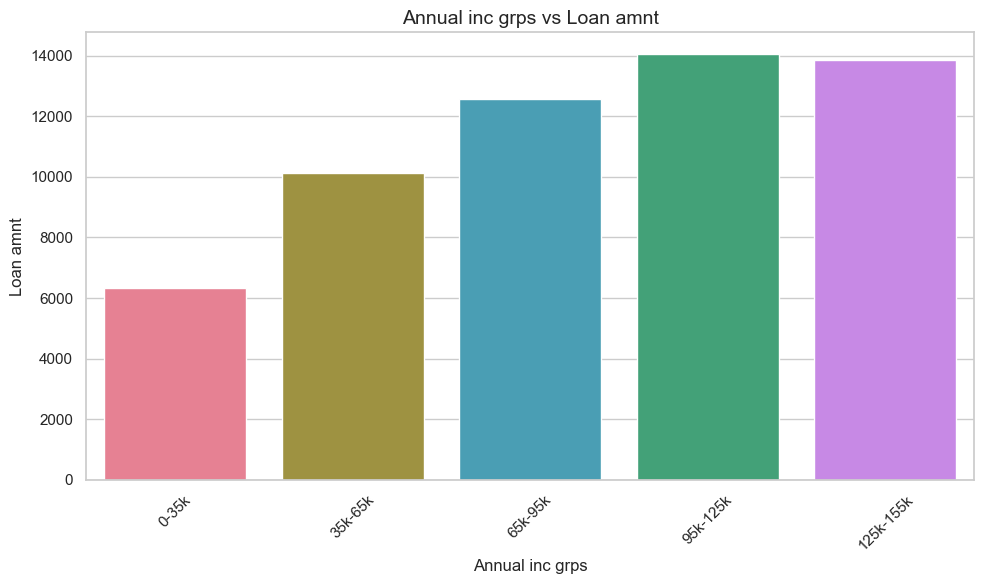

In [194]:
# Loan Amount vs Annual Income
plot_comparison(charged_off_data, x="annual_inc_grps", y="loan_amnt", plot_type="bar")

# Observation - As the annual income increases, the loan amount also increases for the higher income grps

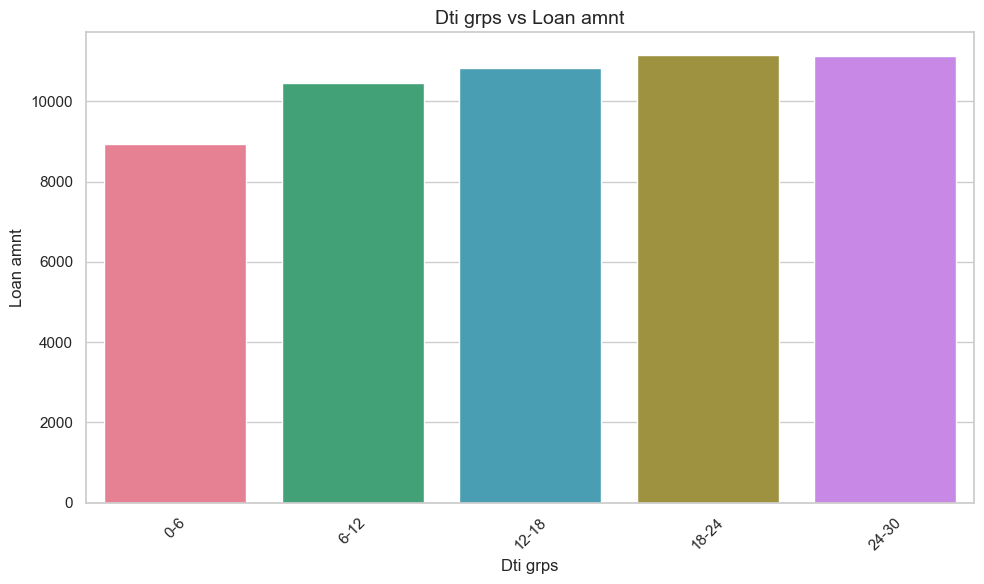

In [195]:
# Loan Amount VS DTI
plot_comparison(charged_off_data, x="dti_grps", y="loan_amnt", plot_type="bar")

# Observation - As the DTI increases, loan amount also increases. Higher DTI groups require higher loan amounts 

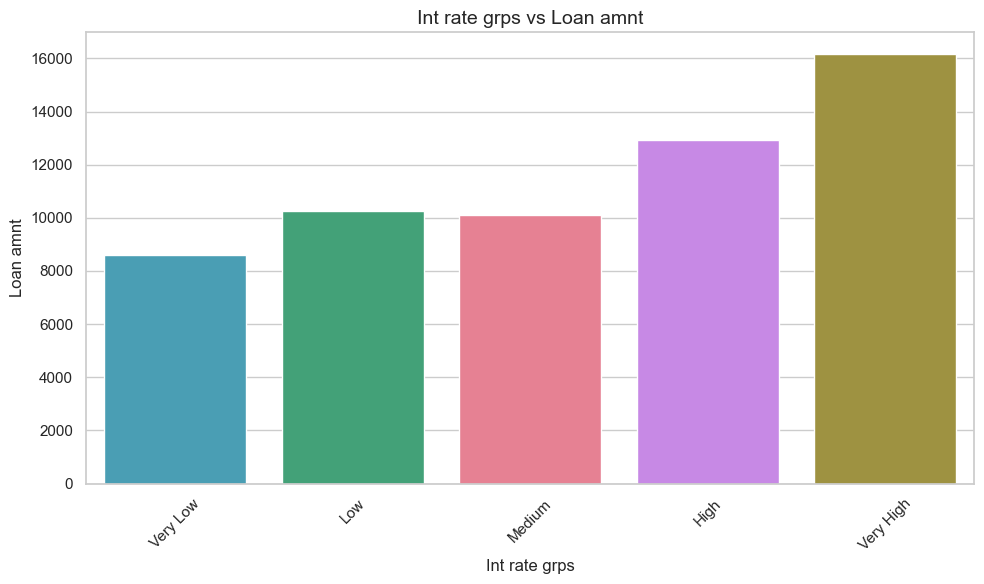

In [196]:
# Loan Amount VS Interest Rates
plot_comparison(charged_off_data, x="int_rate_grps", y="loan_amnt", plot_type="bar")

# Observation - Applicants with very high interest rates tend to take higher loan amounts increasting the possibility of defaulting

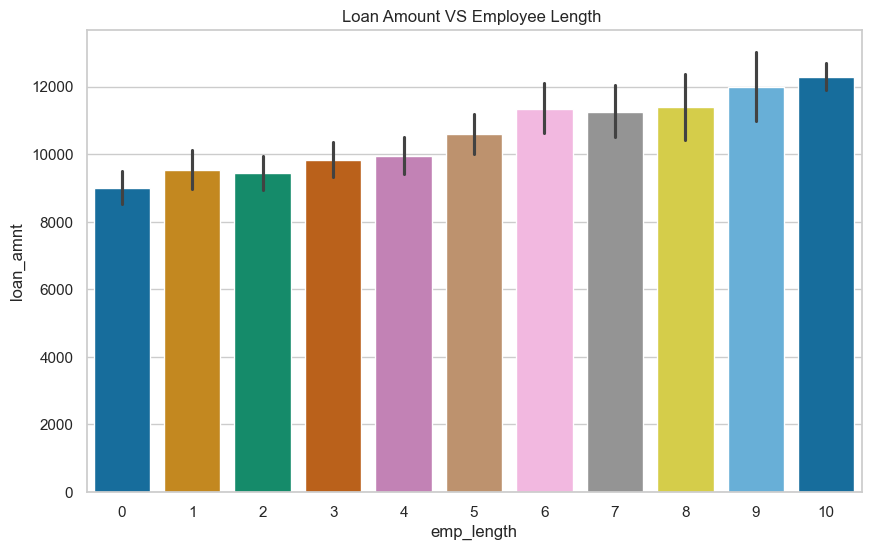

In [197]:
plt.figure(figsize=(10, 6))
sns.barplot(x = 'emp_length',y='loan_amnt',data=charged_off_data,palette='colorblind')
plt.title('Loan Amount VS Employee Length ')
plt.show()

# Observation - Applicants who have more than 10+ years of experience tend to take higher amount of loans

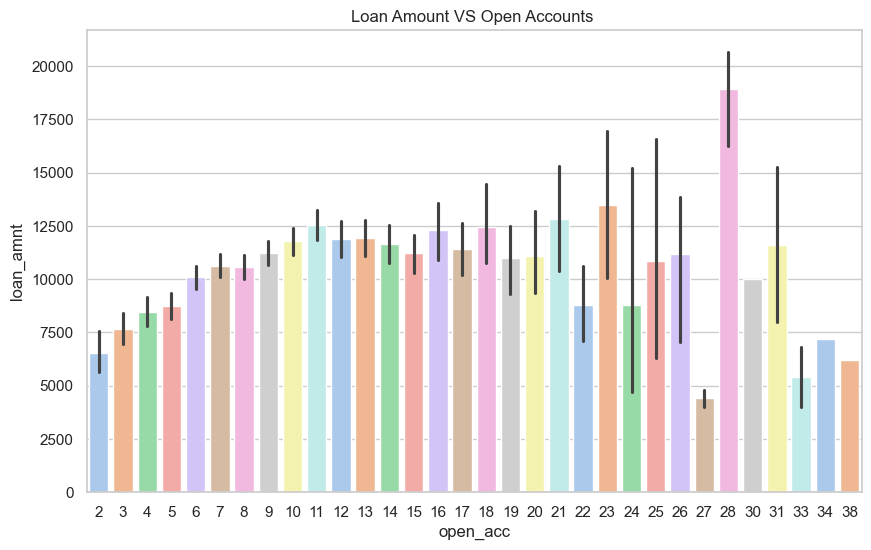

In [198]:
plt.figure(figsize=(10, 6))
sns.barplot(x = 'open_acc',y='loan_amnt',data=charged_off_data,palette='pastel')
plt.title('Loan Amount VS Open Accounts ')
plt.show()

# Observation - Applicants with higher amount of open accounts tend to take higher amount of loans but 
#               there is a variability.

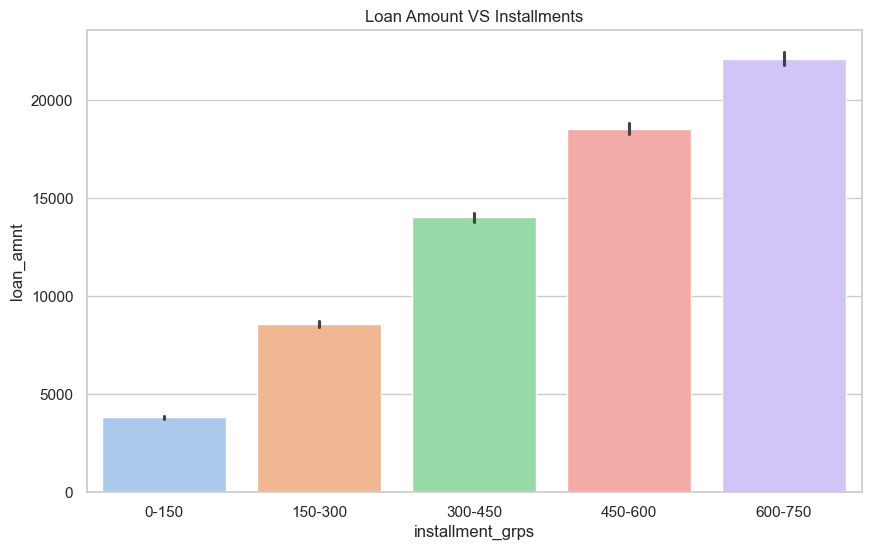

In [199]:
plt.figure(figsize=(10, 6))
sns.barplot(x = 'installment_grps',y='loan_amnt',data=charged_off_data,palette='pastel')
plt.title('Loan Amount VS Installments')
plt.show()

# Observation - Loan Applicants with higher number of installments have a higher tendency to default on their loans

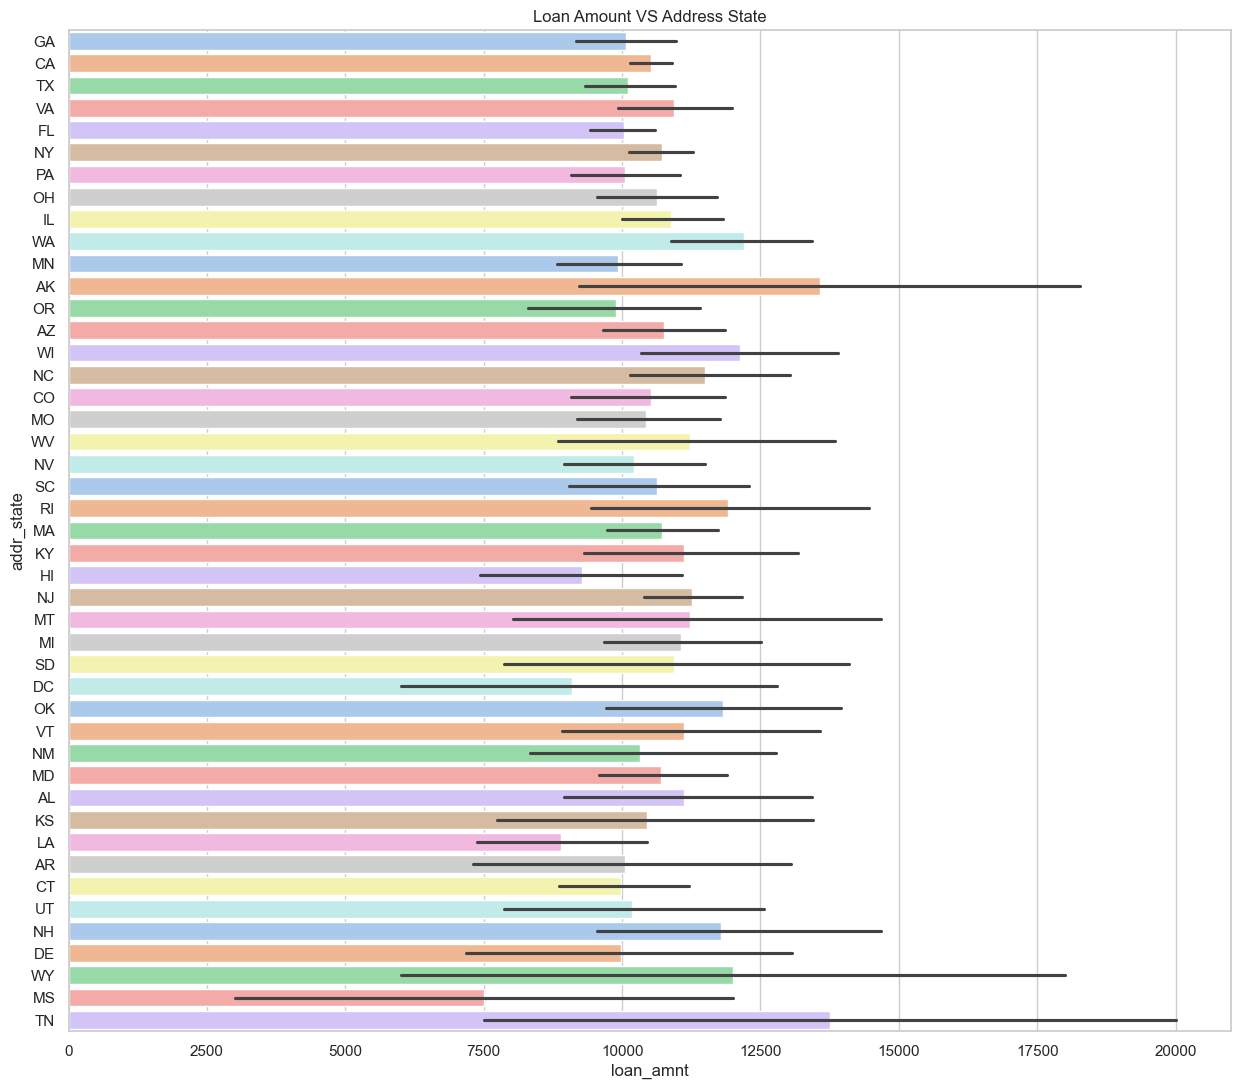

In [200]:
plt.figure(figsize=(15, 13))
sns.barplot(y = 'addr_state',x='loan_amnt',data=charged_off_data,palette='pastel')
plt.title('Loan Amount VS Address State')
plt.show()

# Observation - Applicants from State 'TN' and 'AK have highest number of loan amounts having a tendency to default on their loans

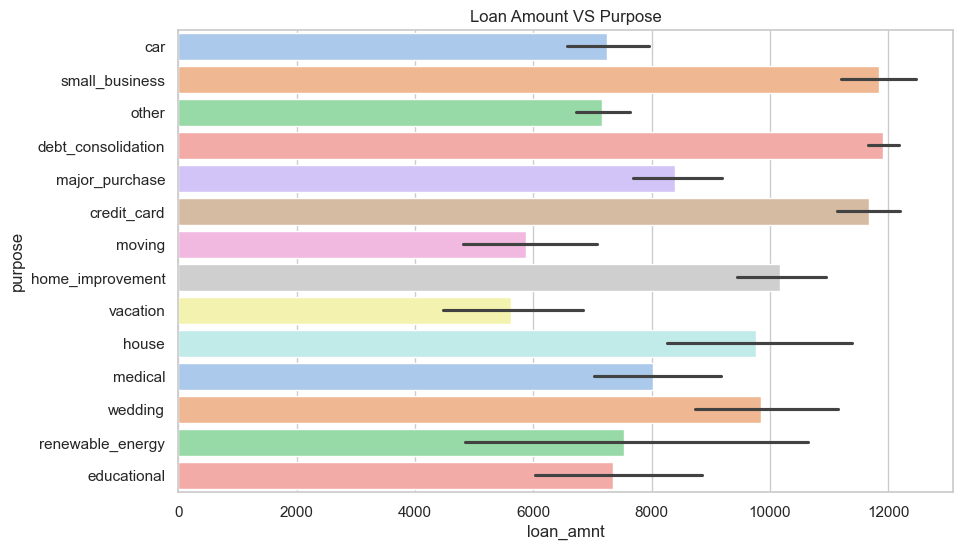

In [201]:
plt.figure(figsize=(10, 6))
sns.barplot(y = 'purpose',x='loan_amnt',data=charged_off_data,palette='pastel')
plt.title('Loan Amount VS Purpose')
plt.show()

# Observation - Applicants who have small business or who are consolidating their debts tend to have higher 
#               loan amounts indicating defaulting on their loan.

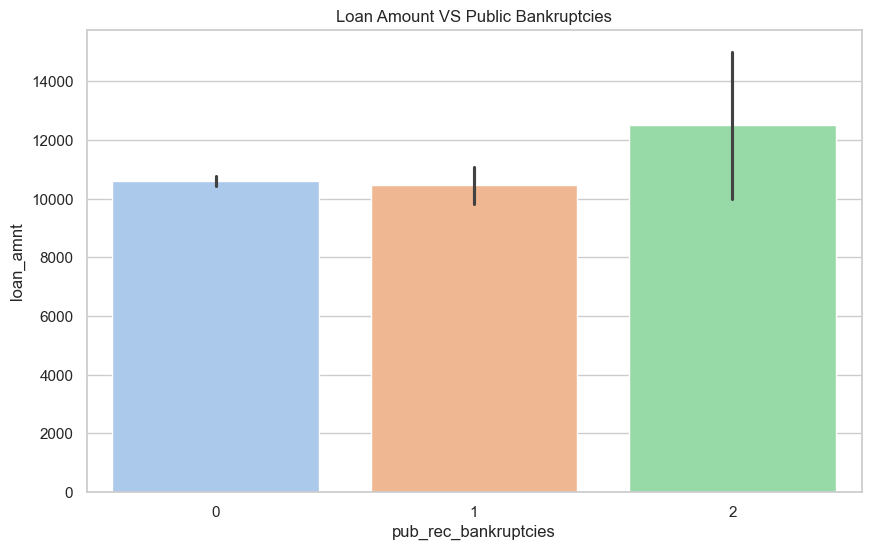

In [202]:
plt.figure(figsize=(10, 6))
sns.barplot(x = 'pub_rec_bankruptcies',y='loan_amnt',data=charged_off_data,palette='pastel')
plt.title('Loan Amount VS Public Bankruptcies')
plt.show()

# Observation - Applicants who have the record of higher public bankruptcies show a higher tendency in loan default.

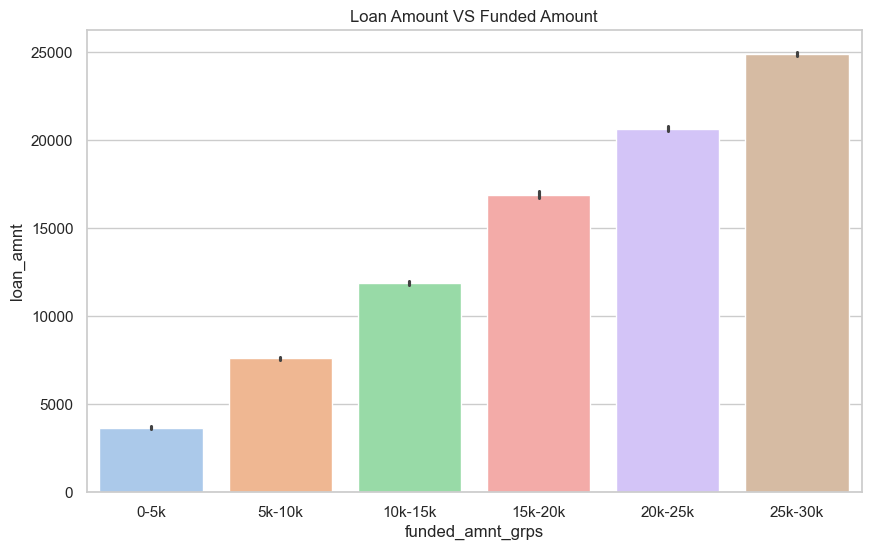

In [203]:
plt.figure(figsize=(10, 6))
sns.barplot(x = 'funded_amnt_grps',y='loan_amnt',data=charged_off_data,palette='pastel')
plt.title('Loan Amount VS Funded Amount')
plt.show()

# Observation - Loan applicants having higher funded amounts tend to default on their loans as compared to other funded amount groups.

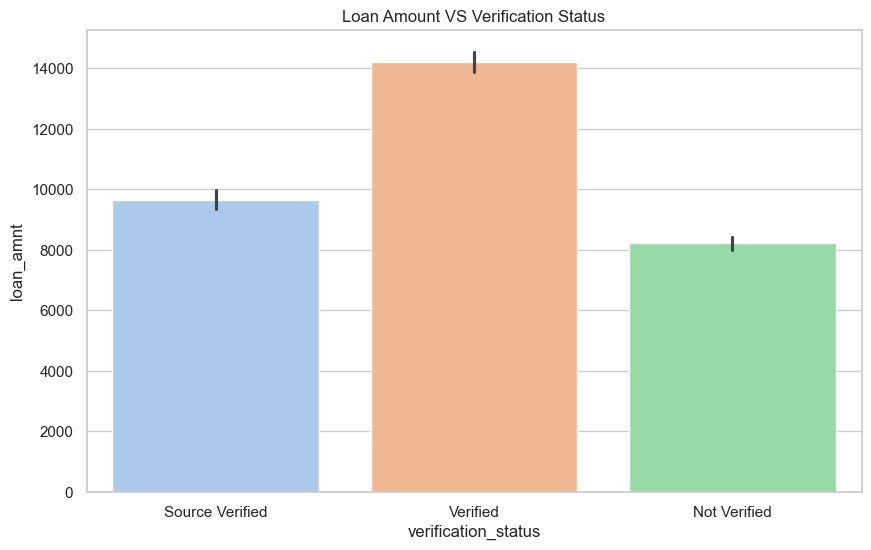

In [204]:
plt.figure(figsize=(10, 6))
sns.barplot(x = 'verification_status',y='loan_amnt',data=charged_off_data,palette='pastel')
plt.title('Loan Amount VS Verification Status')
plt.show()

# Observation - Surprisingly, loan applicants having verification status as Verified have a higher chance in loan defaulting.

# Multivariate Analysis

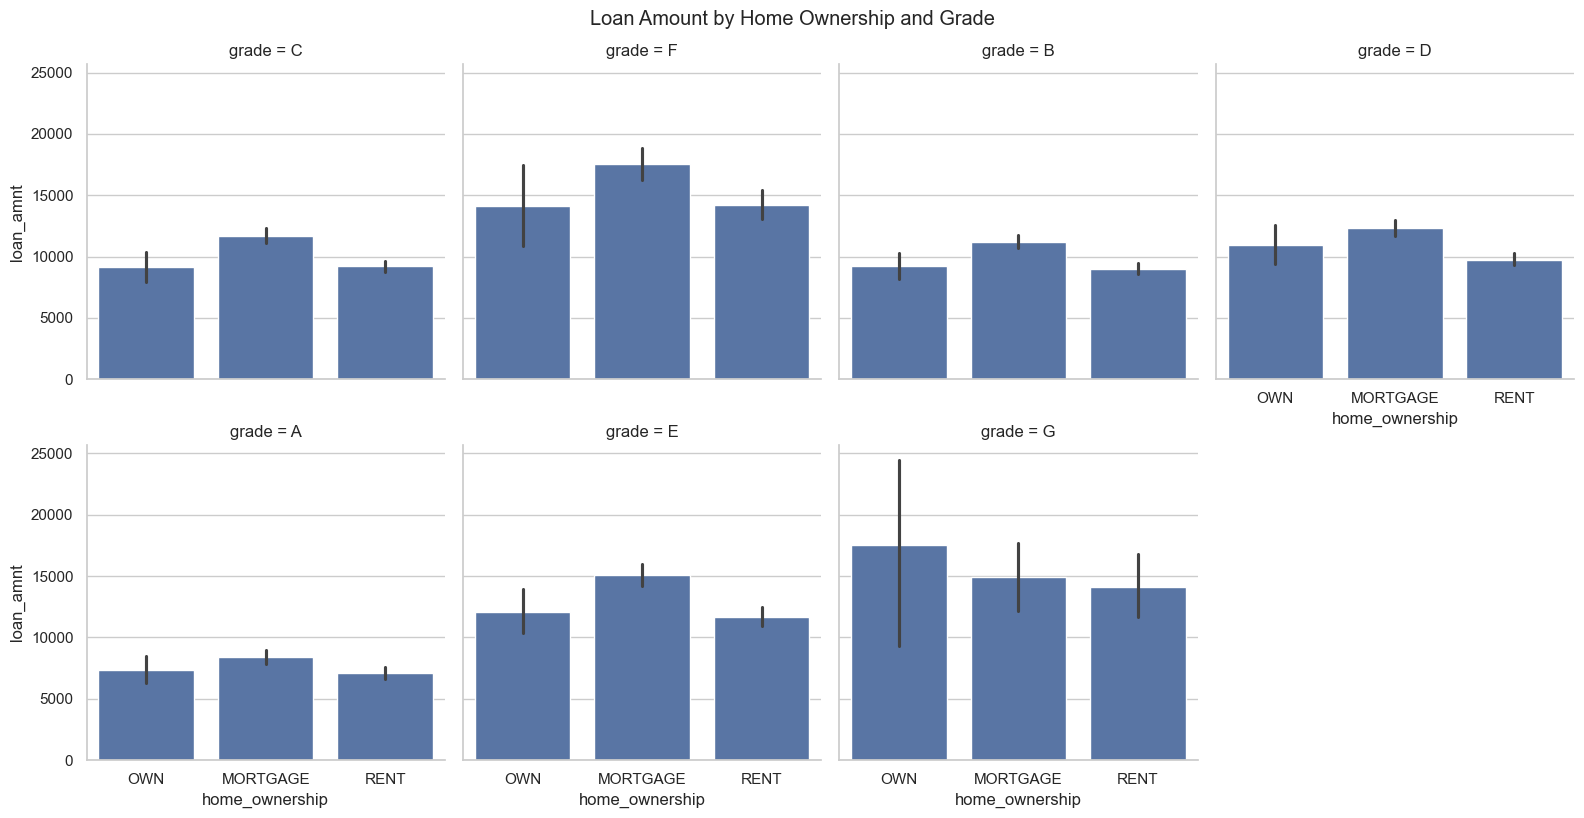

In [211]:
# Facet grid for loan amount and interest rate by grade
g = sns.FacetGrid(charged_off_data, col="grade", col_wrap=4, height=4, sharey=True)
g.map(sns.barplot, "home_ownership", "loan_amnt", order=["OWN", "MORTGAGE", "RENT"])
g.fig.suptitle("Loan Amount by Home Ownership and Grade", y=1.02)
plt.show()


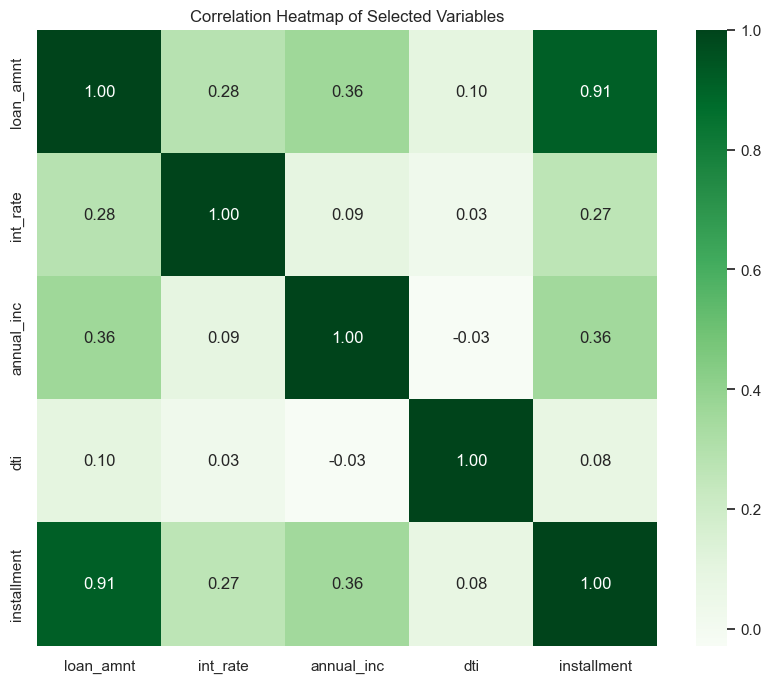

In [218]:
selected_columns = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'installment']
corr_matrix = charged_off_data[selected_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="Greens", fmt=".2f")
plt.title("Correlation Heatmap of Selected Variables")
plt.show()

# Observation - 
# Loan amount and annual income have a moderately positive correlation

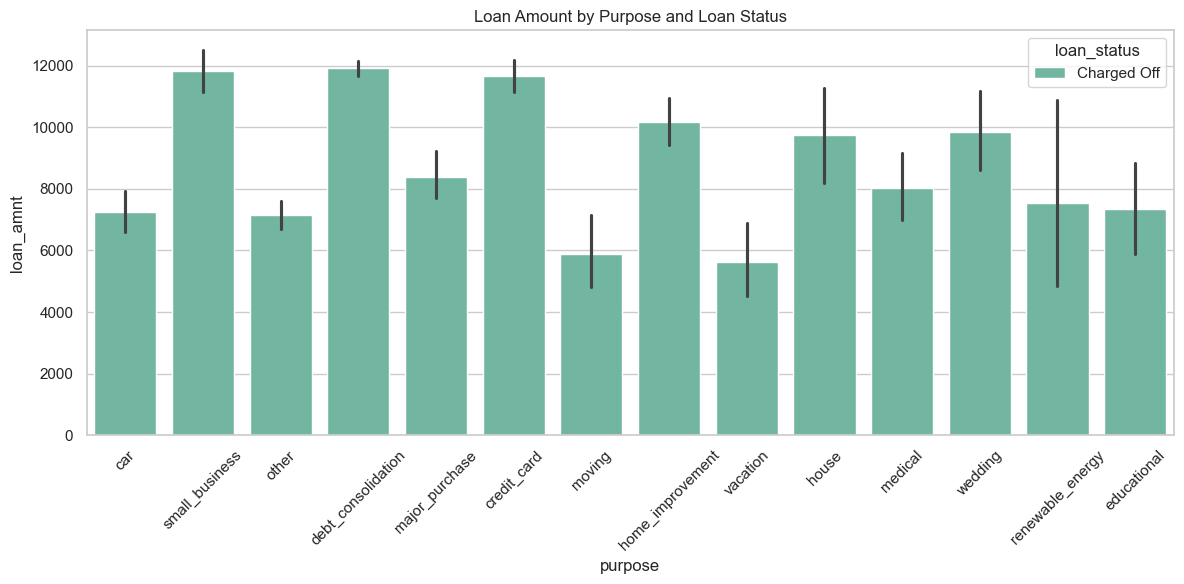

In [214]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=charged_off_data,
    x="purpose", y="loan_amnt", hue="loan_status",
    palette="Set2"
)
plt.xticks(rotation=45)
plt.title("Loan Amount by Purpose and Loan Status")
plt.tight_layout()
plt.show()

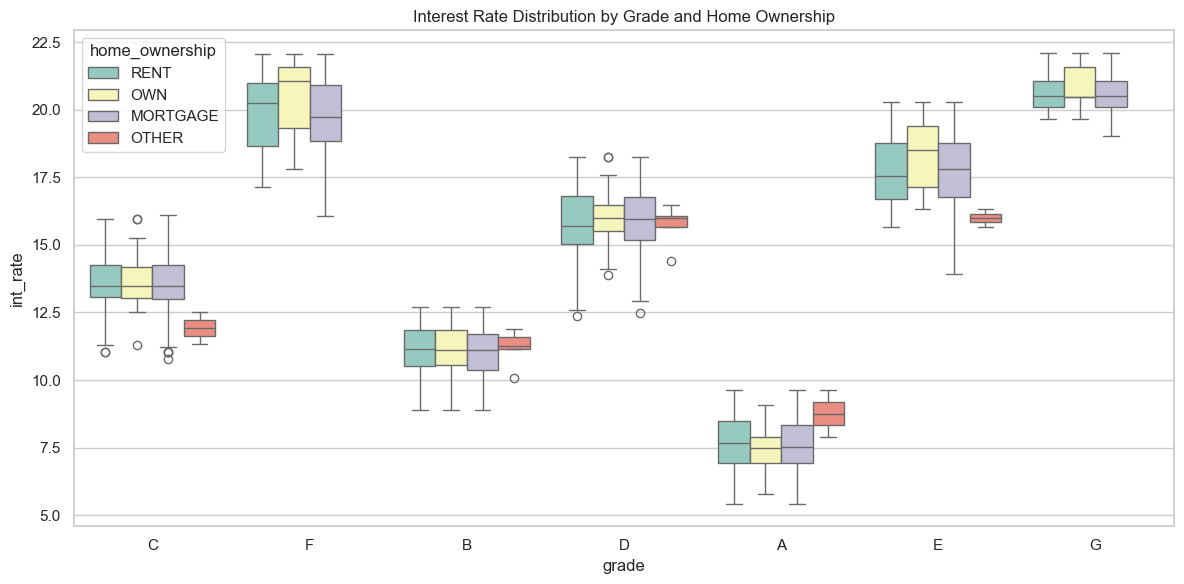

In [216]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=charged_off_data,
    x="grade", y="int_rate", hue="home_ownership",
    palette="Set3"
)
plt.title("Interest Rate Distribution by Grade and Home Ownership")
plt.tight_layout()
plt.show()